# Disaster Tweets

## Description
This is notebook to build RNN for disaster tweet classification. The intention is use this RNN to classify tweet (text) if it's a about a real disaster or not. Our aim is get classification model with the most accuracy possible.

source : https://www.kaggle.com/competitions/nlp-getting-started/data

data type : CSV (5 columns)

data size : 7613 rows (988 KB)

Describe for each column
- id : a unique identifier for each tweet
- text : the text of the tweet
- location : the location the tweet was sent from (may be blank)
- keyword : a particular keyword from the tweet (may be blank)
- target : this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential

In [2]:
data = pd.read_csv('./nlp-getting-started/train.csv')
test_data = pd.read_csv('./nlp-getting-started/test.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test_data.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Since test data have empty keyword and location. So, I will use only text data to train the model.

In [7]:
print(data['text'].nunique())

7503


We have duplicated data. Let's see if same text have the same target or class or not.

In [8]:
groupped = data.groupby('text')
c = 1
for k,v in groupped:
    if v.shape[0]>1:
        if v['target'].nunique() > 1:
          print(c, ' target nunique = ', v['target'].nunique(), ' id nunique = ', v['id'].nunique())
        c=c+1

1  target nunique =  2  id nunique =  3
8  target nunique =  2  id nunique =  3
12  target nunique =  2  id nunique =  4
25  target nunique =  2  id nunique =  3
26  target nunique =  2  id nunique =  2
33  target nunique =  2  id nunique =  6
34  target nunique =  2  id nunique =  3
36  target nunique =  2  id nunique =  2
38  target nunique =  2  id nunique =  2
40  target nunique =  2  id nunique =  2
45  target nunique =  2  id nunique =  2
49  target nunique =  2  id nunique =  2
53  target nunique =  2  id nunique =  6
54  target nunique =  2  id nunique =  4
61  target nunique =  2  id nunique =  3
66  target nunique =  2  id nunique =  2
68  target nunique =  2  id nunique =  4
69  target nunique =  2  id nunique =  2


There are 69 set of duplication and some of them have 2 classes (target). We must clean up this mess.

## Clean Up
I will remove all data in duplication in set with 2 classes and for duplication set with 1 class I will keep only one row from each set and remove the rest.

In [9]:
toDel = []
for k,v in groupped:
    if v.shape[0]>1:
      if v['target'].nunique() > 1:
        toDel.extend(v['id'])
      else:
        toDel.extend(v['id'][1:])
data = data[~data['id'].isin(toDel)]
print('deleted ', len(toDel), 'rows')

deleted  128 rows


In [10]:
print('cleaned data = ', data.shape[0], ' rows')

cleaned data =  7485  rows


In [11]:
labels, labels_count = np.unique(data['target'], return_counts=True)
print(labels)
print(labels_count)

[0 1]
[4297 3188]


We have 4,297 negative data and 3,188 positive data.

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
word_index = tokenizer.word_index

In [13]:
len(word_index)

22675

We have 22,675 unique words.

In [14]:
# map word to index
data_seq = tokenizer.texts_to_sequences(data.text)

In [15]:
# count word for each text to df
words = list(word_index.keys())
wc = tokenizer.texts_to_matrix(data.text, mode='count')
wcdf = pd.DataFrame(wc, columns=['<oov>'] + words)

In [16]:
wcdf.sum().describe()

count    22676.000000
mean         5.551111
std         66.981731
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       4709.000000
dtype: float64

In [17]:
wcdf.sum().sort_values(ascending=False).head()

t       4709.0
co      4700.0
http    4273.0
the     3180.0
a       2151.0
dtype: float64

Those are top words in training data.

None    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

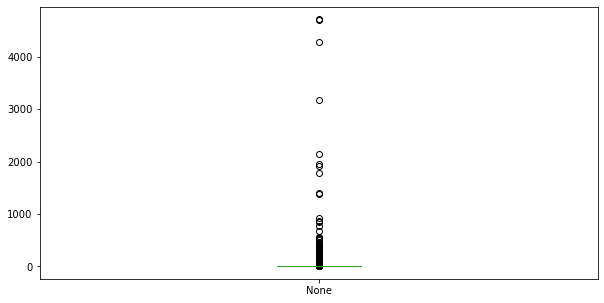

In [18]:
wcdf.sum().plot(kind="box", subplots=True, figsize =(10, 5))

From boxplot above, we can see that most of tweet have less than 1,000 words.

In [19]:
wcdf.sum(axis=1).describe()

count    7485.000000
mean       16.817234
std         5.926167
min         1.000000
25%        13.000000
50%        17.000000
75%        21.000000
max        33.000000
dtype: float64

We have avearge around 17 words per tweet.

<AxesSubplot:>

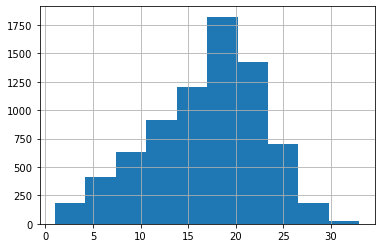

In [20]:
wcdf.sum(axis=1).hist(bins=10)

<AxesSubplot:title={'center':'count'}, xlabel='target'>

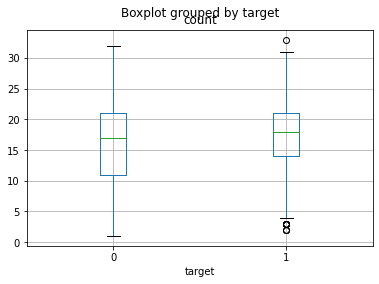

In [21]:
pwcdf = pd.concat([wcdf.sum(axis=1), data['target'].reset_index(drop=True)], axis=1, keys=['count', 'target'])
pwcdf.boxplot(column=['count'], by='target')

### Analysis
We have 22,675 unique words which too much for training So, I would reduce it before reed to the model. The largest of tweet have 33 words. So, I think we can crate CNN with 33 features.

## Classification
First, I will try with simple CNN model as based line. Then, We will add more complexity to the model. I will also, try with small vocab size.

Spliting data in to train and validation (validation for 20%).

In [22]:
x_train, x_val, y_train, y_val = train_test_split(data.text, data.target, test_size=0.2, random_state=1992)

In [23]:
# create vocab only from train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [24]:
len(word_index)

19300

In [25]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

We are going to padding. Therefore We must check longest of test data before doing it.

In [26]:
test_data_seq = tokenizer.texts_to_sequences(test_data.text)

In [27]:
max = 0
for s in test_data_seq:
  if max<len(s):
    max = len(s)
max

30

So, We will pad to 33 words.

In [28]:
pad_x_train = tf.keras.utils.pad_sequences(x_train_seq, maxlen = 33)
pad_x_val = tf.keras.utils.pad_sequences(x_val_seq, maxlen = 33)
pad_x_test = tf.keras.utils.pad_sequences(test_data_seq, maxlen = 33)

Next, we will build simple model as based line.

In [29]:
model0 = Sequential()
model0.add(layers.Embedding(22675, 64, input_length = 33))
model0.add(layers.SimpleRNN(128))
model0.add(layers.Dense(1, activation = 'sigmoid'))
model0.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 64)            1451200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24704     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1476033 (5.63 MB)
Trainable params: 1476033 (5.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
history = model0.fit(pad_x_train, y_train, validation_data = (pad_x_val, y_val), epochs = 20)

Epoch 1/20
188/188 [==============================] - 2s 7ms/step - loss: 0.2274 - accuracy: 0.6353 - val_loss: 0.2445 - val_accuracy: 0.5925
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.0857 - accuracy: 0.8960 - val_loss: 0.2884 - val_accuracy: 0.5939
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.0199 - accuracy: 0.9775 - val_loss: 0.2948 - val_accuracy: 0.5972
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.0112 - accuracy: 0.9883 - val_loss: 0.2784 - val_accuracy: 0.6032
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.0084 - accuracy: 0.9910 - val_loss: 0.2782 - val_accuracy: 0.5972
Epoch 6/20
188/188 [==============================] - 1s 7ms/step - loss: 0.0056 - accuracy: 0.9937 - val_loss: 0.2591 - val_accuracy: 0.6239
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.0035 - accuracy: 0.9962 - val_loss: 0.2845 - val_accuracy: 0.6039
Epoch 

Now we have our first model which simple but not working well. So, I will try to change to LSTM wihich make model more complex.

In [31]:
model1 = Sequential()
model1.add(layers.Embedding(22675, 64, input_length = 33))
model1.add(layers.LSTM(128))
model1.add(layers.Dense(1, activation = 'sigmoid'))
model1.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 64)            1451200   
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1550145 (5.91 MB)
Trainable params: 1550145 (5.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history = model1.fit(pad_x_train, y_train, validation_data = (pad_x_val, y_val), epochs = 20)

Epoch 1/20
188/188 [==============================] - 4s 19ms/step - loss: 0.1806 - accuracy: 0.7244 - val_loss: 0.1436 - val_accuracy: 0.8043
Epoch 2/20
188/188 [==============================] - 4s 19ms/step - loss: 0.0841 - accuracy: 0.8928 - val_loss: 0.1521 - val_accuracy: 0.7969
Epoch 3/20
188/188 [==============================] - 4s 19ms/step - loss: 0.0381 - accuracy: 0.9532 - val_loss: 0.1633 - val_accuracy: 0.7889
Epoch 4/20
188/188 [==============================] - 3s 18ms/step - loss: 0.0171 - accuracy: 0.9806 - val_loss: 0.1717 - val_accuracy: 0.7816
Epoch 5/20
188/188 [==============================] - 3s 18ms/step - loss: 0.0091 - accuracy: 0.9906 - val_loss: 0.1815 - val_accuracy: 0.7735
Epoch 6/20
188/188 [==============================] - 3s 18ms/step - loss: 0.0063 - accuracy: 0.9933 - val_loss: 0.1911 - val_accuracy: 0.7555
Epoch 7/20
188/188 [==============================] - 3s 19ms/step - loss: 0.0052 - accuracy: 0.9947 - val_loss: 0.2056 - val_accuracy: 0.7355

From result above I think it's overfitted. Because validation accuracy is not increase when test accuracy is increase.

So, I will try to reduce vocab size which might fix overfitted issue.

I think we can use only 1500 words to train.

In [33]:
# new tokenizer with num_words = 1500
vocab = 1500
tokenizer = Tokenizer(num_words = vocab)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [34]:
# convert to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
test_data_seq = tokenizer.texts_to_sequences(test_data.text)

In [35]:
# padding
pad_x_train = tf.keras.utils.pad_sequences(x_train_seq, maxlen = 33)
pad_x_val = tf.keras.utils.pad_sequences(x_val_seq, maxlen = 33)
pad_x_test = tf.keras.utils.pad_sequences(test_data_seq, maxlen = 33)

Create new model to fit new data with vocab size 1500.

In [36]:
model2 = Sequential()
model2.add(layers.Embedding(vocab, 64, input_length = 33))
model2.add(layers.LSTM(128))
model2.add(layers.Dense(1, activation = 'sigmoid'))
model2.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 64)            96000     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 194945 (761.50 KB)
Trainable params: 194945 (761.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
epochs = 20
history = model2.fit(pad_x_train, y_train, validation_data = (pad_x_val, y_val), epochs = epochs)

Epoch 1/20
188/188 [==============================] - 3s 15ms/step - loss: 0.1797 - accuracy: 0.7345 - val_loss: 0.1488 - val_accuracy: 0.7856
Epoch 2/20
188/188 [==============================] - 3s 15ms/step - loss: 0.1240 - accuracy: 0.8322 - val_loss: 0.1444 - val_accuracy: 0.8003
Epoch 3/20
188/188 [==============================] - 3s 15ms/step - loss: 0.1101 - accuracy: 0.8555 - val_loss: 0.1603 - val_accuracy: 0.7902
Epoch 4/20
188/188 [==============================] - 3s 15ms/step - loss: 0.1021 - accuracy: 0.8672 - val_loss: 0.1521 - val_accuracy: 0.7869
Epoch 5/20
188/188 [==============================] - 3s 16ms/step - loss: 0.0920 - accuracy: 0.8843 - val_loss: 0.1575 - val_accuracy: 0.7829
Epoch 6/20
188/188 [==============================] - 3s 15ms/step - loss: 0.0838 - accuracy: 0.8950 - val_loss: 0.1796 - val_accuracy: 0.7689
Epoch 7/20
188/188 [==============================] - 3s 15ms/step - loss: 0.0782 - accuracy: 0.9046 - val_loss: 0.1772 - val_accuracy: 0.7756

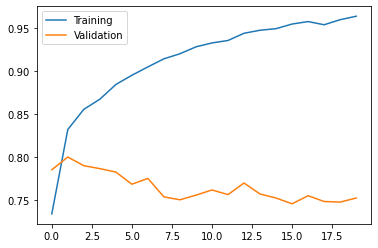

In [38]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

This model seems overfitted. So, I will add dropout and regularizer.

In [39]:
model3 = Sequential()
model3.add(layers.Embedding(vocab, 64, input_length = 33, embeddings_regularizer='L2'))
model3.add(layers.LSTM(64))
model3.add(layers.Dense(64, activation = 'relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1, activation = 'sigmoid'))
model3.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 33, 64)            96000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 133249 (520.50 KB)
Trainable params: 133249 (520.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
epochs = 30
history = model3.fit(pad_x_train, y_train, validation_data = (pad_x_val, y_val), epochs = epochs)

Epoch 1/30
188/188 [==============================] - 2s 8ms/step - loss: 0.2907 - accuracy: 0.6421 - val_loss: 0.2183 - val_accuracy: 0.6981
Epoch 2/30
188/188 [==============================] - 1s 7ms/step - loss: 0.2109 - accuracy: 0.7493 - val_loss: 0.2016 - val_accuracy: 0.7709
Epoch 3/30
188/188 [==============================] - 1s 7ms/step - loss: 0.1945 - accuracy: 0.7796 - val_loss: 0.1908 - val_accuracy: 0.7842
Epoch 4/30
188/188 [==============================] - 1s 7ms/step - loss: 0.1834 - accuracy: 0.7928 - val_loss: 0.1804 - val_accuracy: 0.7923
Epoch 5/30
188/188 [==============================] - 1s 7ms/step - loss: 0.1740 - accuracy: 0.8049 - val_loss: 0.1768 - val_accuracy: 0.7936
Epoch 6/30
188/188 [==============================] - 1s 7ms/step - loss: 0.1676 - accuracy: 0.8130 - val_loss: 0.1902 - val_accuracy: 0.7642
Epoch 7/30
188/188 [==============================] - 1s 7ms/step - loss: 0.1646 - accuracy: 0.8185 - val_loss: 0.1780 - val_accuracy: 0.7916
Epoch 

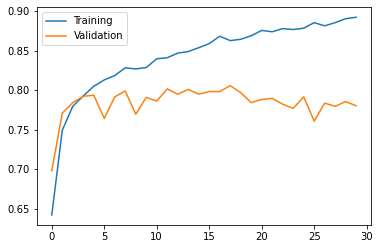

In [41]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

Overfitted issue seems to be better. But still not total resolved. So, I will add more dropout.

In [42]:
model4 = Sequential()
model4.add(layers.Embedding(vocab, 64, input_length = 33, embeddings_regularizer='L2'))
model4.add(layers.GRU(128, dropout=0.2))
model4.add(layers.Dense(128, activation = 'relu'))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(1, activation = 'sigmoid'))
model4.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 33, 64)            96000     
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 187137 (731.00 KB)
Trainable params: 187137 (731.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
epochs = 20
history = model4.fit(pad_x_train, y_train, validation_data = (pad_x_val, y_val), epochs = epochs)

Epoch 1/20
188/188 [==============================] - 3s 14ms/step - loss: 0.2875 - accuracy: 0.6638 - val_loss: 0.2067 - val_accuracy: 0.7562
Epoch 2/20
188/188 [==============================] - 3s 14ms/step - loss: 0.2080 - accuracy: 0.7637 - val_loss: 0.1973 - val_accuracy: 0.7849
Epoch 3/20
188/188 [==============================] - 3s 14ms/step - loss: 0.1914 - accuracy: 0.7916 - val_loss: 0.1914 - val_accuracy: 0.7923
Epoch 4/20
188/188 [==============================] - 3s 14ms/step - loss: 0.1847 - accuracy: 0.8006 - val_loss: 0.1830 - val_accuracy: 0.7862
Epoch 5/20
188/188 [==============================] - 3s 14ms/step - loss: 0.1799 - accuracy: 0.8049 - val_loss: 0.1831 - val_accuracy: 0.7969
Epoch 6/20
188/188 [==============================] - 3s 13ms/step - loss: 0.1796 - accuracy: 0.8031 - val_loss: 0.1835 - val_accuracy: 0.7902
Epoch 7/20
188/188 [==============================] - 3s 14ms/step - loss: 0.1731 - accuracy: 0.8113 - val_loss: 0.1863 - val_accuracy: 0.7949

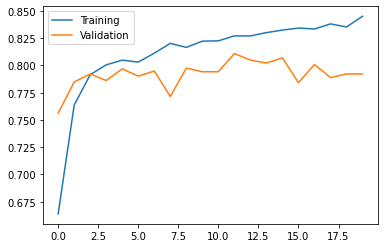

In [44]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

This model looking good for me. So, I will use it to perdict test data. and submit to kaggle.

In [45]:
predictions = model4.predict(pad_x_test)
pre_bi = (predictions.flatten() >= 0.5).astype(int)
output = pd.DataFrame({'id': test_data.id, 'target': pre_bi})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

102/102 [==============================] - 0s 3ms/step
Your submission was successfully saved!


This model has score 0.78332. This model still a overfitted. I will try a new model with more dropout.

In [46]:
model5 = Sequential()
model5.add(layers.Embedding(vocab, 256, input_length = 33, embeddings_regularizer='L2'))
model5.add(layers.GRU(128, dropout=0.5))
model5.add(layers.Dense(128, activation = 'relu'))
model5.add(layers.Dropout(0.3))
model5.add(layers.Dense(1, activation = 'sigmoid'))
model5.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 33, 256)           384000    
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 548865 (2.09 MB)
Trainable params: 548865 (2.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
epochs = 20
history = model5.fit(pad_x_train, y_train, validation_data = (pad_x_val, y_val), epochs = epochs)

Epoch 1/20
188/188 [==============================] - 5s 23ms/step - loss: 0.4773 - accuracy: 0.6673 - val_loss: 0.2377 - val_accuracy: 0.7562
Epoch 2/20
188/188 [==============================] - 4s 24ms/step - loss: 0.2425 - accuracy: 0.7629 - val_loss: 0.3137 - val_accuracy: 0.6219
Epoch 3/20
188/188 [==============================] - 4s 23ms/step - loss: 0.2291 - accuracy: 0.7842 - val_loss: 0.2175 - val_accuracy: 0.7889
Epoch 4/20
188/188 [==============================] - 4s 22ms/step - loss: 0.2165 - accuracy: 0.7879 - val_loss: 0.2139 - val_accuracy: 0.7896
Epoch 5/20
188/188 [==============================] - 4s 23ms/step - loss: 0.2127 - accuracy: 0.7929 - val_loss: 0.2139 - val_accuracy: 0.7882
Epoch 6/20
188/188 [==============================] - 4s 24ms/step - loss: 0.2048 - accuracy: 0.7994 - val_loss: 0.2056 - val_accuracy: 0.7876
Epoch 7/20
188/188 [==============================] - 4s 24ms/step - loss: 0.2063 - accuracy: 0.7988 - val_loss: 0.2030 - val_accuracy: 0.7963

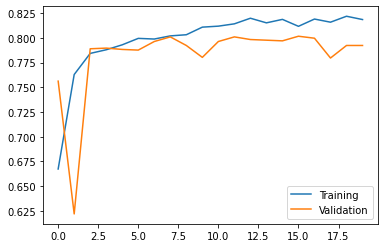

In [48]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

This looks better. So, I will submit again.

In [49]:
predictions = model5.predict(pad_x_test)
pre_bi = (predictions.flatten() >= 0.5).astype(int)
output = pd.DataFrame({'id': test_data.id, 'target': pre_bi})
output.to_csv('submission5.csv', index=False)
print("Your submission was successfully saved!")

102/102 [==============================] - 1s 5ms/step
Your submission was successfully saved!


This model has score 0.78577 which is better a bit.

I want to get better score. So, I try tuning hyperparameter around and comeup with this last model.

P.S. I tried many thing off this notebook. But I think it's a bit too much. Therefore, I did not include those model in this notebook.

In [54]:
model6 = Sequential()
model6.add(layers.Embedding(vocab, 64, input_length = 33, embeddings_regularizer='L2'))
model6.add(layers.GRU(32, dropout=0.1, return_sequences= True))
model6.add(layers.GRU(32, dropout=0.1))
model6.add(layers.Dense(32, activation = 'relu'))
model6.add(layers.Dropout(0.1))
model6.add(layers.Dense(1, activation = 'sigmoid'))
model6.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 33, 64)            96000     
                                                                 
 gru_4 (GRU)                 (None, 33, 32)            9408      
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 112833 (440.75 KB)
Trainable params: 112

In [55]:
epochs = 15
history = model6.fit(pad_x_train, y_train, validation_data = (pad_x_val, y_val), epochs = epochs)

Epoch 1/15
188/188 [==============================] - 3s 9ms/step - loss: 0.2897 - accuracy: 0.6500 - val_loss: 0.2179 - val_accuracy: 0.7315
Epoch 2/15
188/188 [==============================] - 2s 9ms/step - loss: 0.2124 - accuracy: 0.7587 - val_loss: 0.2043 - val_accuracy: 0.7615
Epoch 3/15
188/188 [==============================] - 2s 9ms/step - loss: 0.1969 - accuracy: 0.7797 - val_loss: 0.1854 - val_accuracy: 0.7956
Epoch 4/15
188/188 [==============================] - 2s 9ms/step - loss: 0.1892 - accuracy: 0.7847 - val_loss: 0.1888 - val_accuracy: 0.7849
Epoch 5/15
188/188 [==============================] - 2s 9ms/step - loss: 0.1801 - accuracy: 0.8006 - val_loss: 0.1866 - val_accuracy: 0.7816
Epoch 6/15
188/188 [==============================] - 2s 9ms/step - loss: 0.1728 - accuracy: 0.8095 - val_loss: 0.1803 - val_accuracy: 0.7969
Epoch 7/15
188/188 [==============================] - 2s 9ms/step - loss: 0.1705 - accuracy: 0.8074 - val_loss: 0.1757 - val_accuracy: 0.7936
Epoch 

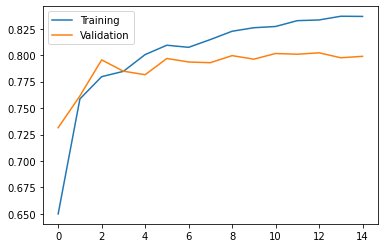

In [56]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [57]:
predictions = model6.predict(pad_x_test)
pre_bi = (predictions.flatten() >= 0.5).astype(int)
output = pd.DataFrame({'id': test_data.id, 'target': pre_bi})
output.to_csv('submission6.csv', index=False)
print("Your submission was successfully saved!")

102/102 [==============================] - 0s 2ms/step
Your submission was successfully saved!


Score for submit this prediction to Kaggle = 0.78486

## Conclusion
For this problem first we look at overview of the data. We did analysis based on our visualizations. Then, we clean it up (remove dulicate data). Then, we build classification model with RNN and tune it to get the best model (based on score from Kaggle our best model has score = 0.78577).

Most of my models suffer from overfitted problem. I did tried a lot of thing to remove it. I can't remove it, but it's getting better with dropout, reduced vocab size and regularization. Future Improvement would be study new way to reduce overfitted and apply it the our models.

From all of this I know how to do the classification from scratch with python and how to use kaggle.

github : https://github.com/Satjarporn/Disaster